Najprej bomo prevedli celoštevilski linearni program iz navodil v funkcijo `alpha_od(G)`. Funkcija vrne velikost največje lihe neodvisne množice v grafu $G$.

In [1]:
def alpha_od(G):
    """
    Compute the size of the maximum odd independent set in the graph G.
    """
    from sage.numerical.mip import MixedIntegerLinearProgram
    
    n = G.order()
    V = G.vertices()
    
    # Create the mixed integer linear program
    mip = MixedIntegerLinearProgram(maximization=True)
    
    # Define variables
    x = mip.new_variable(binary=True) # Indicator if vertex v is in the independent set
    y = mip.new_variable(binary=True) # Indicator if vertex v has neighbors in the independent set
    z = mip.new_variable(integer=True) # Counter for the vertex v
    
    # Objective function
    mip.set_objective(mip.sum(x[v] for v in V))
    
    # Constraints
    for u, v in G.edges(labels=False):
        mip.add_constraint(x[u] + x[v] <= 1)
        
    for u in V:
        sum_neighbors = mip.sum(x[v] for v in G.neighbors(u))
        mip.add_constraint(sum_neighbors <= n * y[u])
        mip.add_constraint(y[u] + sum_neighbors == 2*z[u])
    
    # Solve the MIP
    return int(mip.solve())

Preverimo delovanje `alpha_od(G)` na nekaterih manjših grafih.

In [2]:
from sage.all import Graph
from sage.graphs.graph_generators import graphs

P4 = graphs.PathGraph(4)
C4 = graphs.CycleGraph(4)
C5 = graphs.CycleGraph(5)

for name, G in [("P4", P4), ("C4", C4), ("C5", C5)]:
    print(name, "alpha_od =", alpha_od(G))

P4 alpha_od = 2
C4 alpha_od = 1
C5 alpha_od = 1


Zapisali bomo tudi CLP za določanje najmanjše število barv za krepko liho barvanje grafa $G$.

In [3]:
def chi_so(G):
    """
    Compute the size of the minimum strong odd coloring of the graph G.
    """
    from sage.numerical.mip import MixedIntegerLinearProgram
    
    n = G.order()
    V = G.vertices()
    
    # Create the mixed integer linear program
    mip = MixedIntegerLinearProgram(maximization=False)
    
    # Define variables
    x = mip.new_variable(binary=True) # Indicator if vertex v has color i
    y = mip.new_variable(binary=True) # Indicator if color i is used
    z = mip.new_variable(integer=True) # Counter for vertex v and color i
    w = mip.new_variable(binary=True) # Indicator if color i appears in the neighborhood of vertex v
    
    # Objective function
    mip.set_objective(mip.sum(y[i] for i in range(n))) # n is obvious upper bound on colors
    
    # Constraints
    for v in V:
        mip.add_constraint(mip.sum(x[v, i] for i in range(n)) == 1) # Each vertex gets exactly one color
        
    for u, v in G.edges(labels=False):
        for i in range(n):
            mip.add_constraint(x[u, i] + x[v, i] <= 1) # Adjacent vertices have different colors
            
    for i in range(n):
        mip.add_constraint(mip.sum(x[v, i] for v in V) <= n * y[i]) # If color i is used, y[i] = 1
   
    for v in V:
        for i in range(n):
            sum_neighbors = mip.sum(x[u, i] for u in G.neighbors(v))
            deg = len(G.neighbors(v))
            mip.add_constraint(w[v, i] <= sum_neighbors) # w[v,i] = 0 if color i does not appear in neighborhood of v
            mip.add_constraint(sum_neighbors <= deg * w[v, i]) # w[v,i] = 1 if color i appears in neighborhood of v
            # these two conditions together mean w[v,i] = 1 iff color i appears in neighborhood of v
            mip.add_constraint(w[v, i] + sum_neighbors == 2 * z[v, i]) # Strong odd coloring condition
            mip.add_constraint(z[v, i] >= 0)
    
    # Solve the MIP
    return int(mip.solve())

Prav tako preverimo delovanje `chi_so(G)` na nekaterih majhnih grafih.

In [4]:
P4 = graphs.PathGraph(4)
C4 = graphs.CycleGraph(4)
C5 = graphs.CycleGraph(5)
K34 = graphs.CompleteBipartiteGraph(3, 4)
for name, G in [("P4", P4), ("C4", C4), ("C5", C5), ("K34", K34)]:
    print(name, "chi_so =", chi_so(G))

P4 chi_so = 3
C4 chi_so = 4
C5 chi_so = 5
K34 chi_so = 3


Zapisali bomo tudi funkcijo, ki generira vse grafe dane velikosti $n$ z lastnostjo `alpha_od(G)` = 1 in preverili delovanje za $n = 3$. Ker nekatere velike grafe lahko izločimo že iz pogoja $G.\text{diameter()} > 2$, lahko uporabimo to funkcijo tudi za večje $n$, kakor bi sicer, če bi samo računali CLP za vsak graf $G$.

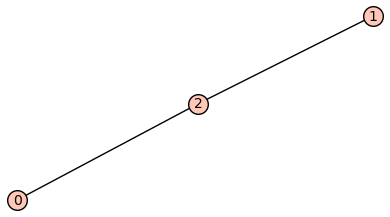

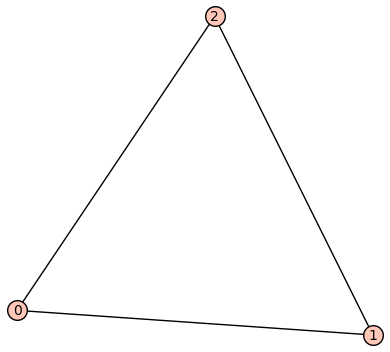

In [ ]:
def generate_graphs_with_alpha_od_equal_to_1(n):
    """
    Iterate over all non-isomorphic graphs with n vertices and return a set of those graphs G for which alpha_od(G) == 1. It is meant to used for n <= 9.
    """
    from sage.graphs.graph_generators import graphs
    
    matches = list()
    for G in graphs(n):
        if G.diameter() > 2:
            continue  # Neccessary condition for alpha_od(G) == 1 is diameter at most 2
        elif alpha_od(G) == 1:
            matches.append(G)
            
    return matches

# Example usage:
graphs_with_alpha_od_1 = generate_graphs_with_alpha_od_equal_to_1(3)
for G in graphs_with_alpha_od_1:
    G.show()

Potrebovali bomo tudi funkcijo `is_claw_free(G)`, ki za dan graf $G$ preveri, če je claw-free. Graf $G$ je claw-free, če ne vsebuje grafa $K_{1,3}$ kot induciran podgraf.

In [ ]:
def is_claw_free(G):
    """
    Check if the given graph G is claw-free. A graph is claw-free if it does not contain K_{1,3} as an induced subgraph.
    """
    from sage.graphs.graph_generators import graphs
    
    claw = graphs.ClawGraph() # K_{1,3}
    return G.subgraph_search(claw, induced=True) is None # subgraph_search returns None if no such subgraph is found

Preverimo delovanje na nekaterih znanih grafih.

In [ ]:
print(is_claw_free(graphs.CycleGraph(10)))
print(is_claw_free(graphs.PathGraph(7)))
print(is_claw_free(graphs.CompleteGraph(6)))
print(is_claw_free(graphs.StarGraph(4)))
print(is_claw_free(graphs.CompleteBipartiteGraph(3,3)))

True
True
True
False
False


Potrebovali bomo funkcijo, ki generira grafe z lastnostjo `alpha_od(G) == 1` za grafe $G = (V, E)$, kjer $|V| \geq 10$. Namreč takih grafov je preveč, da bi lahko preverili za vsakega posebej. Generirali bomo naključen graf, ga popravili, da ima znan potreben pogoj (to je, da je premer $\leq 2$) in šele takrat poračunali `alpha_so(G)`.

In [ ]:
def add_edges_until_diameter_leq_2(G, seed=None):
    """
    Given a graph G, iteratively add edges so that the resulting
    graph H has diameter <= 2.
    
    Process:
    - Compute the diameter path
    - Randomly pick two non-adjacent vertices on that path
    - Add one edge between them
    - Repeat
    
    Returns the modified graph H.
    """
    
    import random
    if seed is not None:
        random.seed(int(seed))

    H = G.copy()
    diameter = H.diameter()

    while diameter > 2:
        # Find one pair of vertices with distance equal to diameter
        vertices = H.vertices()
        
        max_distance_pair = next(
            (
                (vertices[i], vertices[j]) 
                for i in range(len(vertices)) 
                for j in range(i+1, len(vertices)) 
                if H.distance(vertices[i], vertices[j]) == diameter
            ), 
            None
        )

        if max_distance_pair is None: # Safety check
            break

        u, v = max_distance_pair
        # Get the shortest path between u, v
        path = H.shortest_path(u, v)
        
        # Find non-adjacent vertex pairs in the path
        non_adjacent_pairs = [
            (path[i], path[j]) 
            for i in range(len(path)) 
            for j in range(i+2, len(path)) # i+2 ensures non adjacent, since diameter > 2 this exists
            if not H.has_edge(path[i], path[j])
        ]
        
        if non_adjacent_pairs == []: # Safety check
            break

        # Randomly select two vertices to connect
        a, b = random.choice(non_adjacent_pairs)
        H.add_edge(a, b)
        diameter = H.diameter() # update diameter
    return H

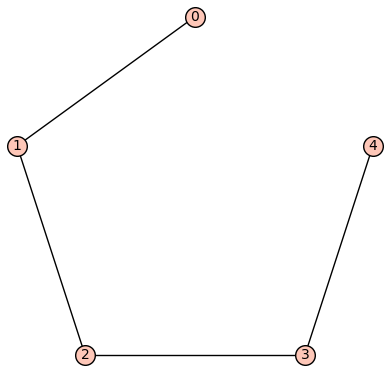

4
2


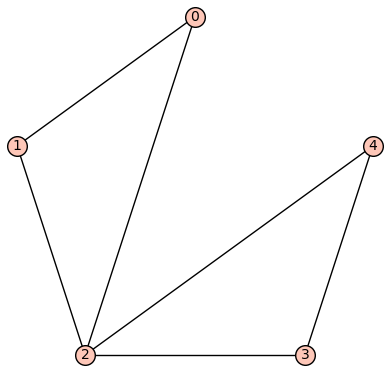

In [ ]:
G = graphs.PathGraph(5)
G.show(layout="circular")
print(G.diameter())
H = add_edges_until_diameter_leq_2(G, seed=42)
print(H.diameter())

H.show(layout="circular")

We will use this function to generate random graphs that are candidates for the `alpha_od(G)` = 1.

In [ ]:
def generate_large_graphs_with_alpha_od_equal_to_1(n, attempts, seed=None):
    """
    Generate 'count' random graphs with 'n' vertices and diameter <= 2,
    and return those graphs G for which alpha_od(G) == 1.
    """
    import random
    if seed is not None:
        random.seed(int(seed))
    
    matches = list()
    seen_isomorphs = set()
    
    for _ in range(attempts):
        G = graphs.RandomGNP(n, p=0.5, seed=random.randint(0, int(1e6)))
        H = add_edges_until_diameter_leq_2(G, seed=random.randint(0, int(1e6)))
        
        canon_repr = H.canonical_label().graph6_string()
        if canon_repr in seen_isomorphs:
            continue # dont compute alpha_od for already seen graphs
        
        if alpha_od(H) == 1:
            seen_isomorphs.add(canon_repr)
            matches.append(H)
            
    return matches

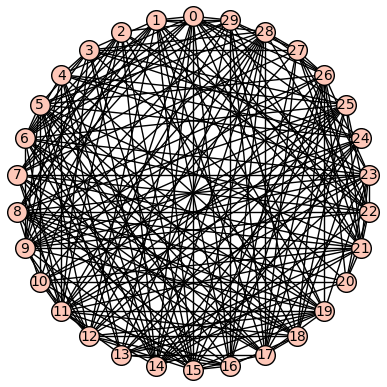

In [ ]:
for G in generate_large_graphs_with_alpha_od_equal_to_1(30, 1, seed=123):
    G.show(layout="circular")

Najdene grafe bomo shranili v datoteko v graph6 formatu. Zato bomo potrebovali funkcijo, ki shranjene grafe prebere iz datoteke.

In [ ]:
def load_graphs_from_graph6(filename):
    """
    Load graphs from a file in graph6 format.
    """
    from sage.graphs.graph import Graph
    graphs = set()
    with open(filename, 'r') as f:
        for line in f:
            graphs.add(Graph(line.strip(), immutable=True)) # immutable for hashing
    return graphs

Z uporabo definiranih funkcij bomo shranili grafe s to lastnostjo v datoteko `graphs_with_alpha_od_1.g6`. Za grafe do velikosti do vključno $n = 9$ bomo poiskali kar vse grafe, za grafe velikosti od $n = 10$ do $n = 30$ bomo pa uporabili verjetnostno konstrukcijo, kjer bomo imeli 500 kandidatov, za katere bomo preverili lastnost.

In [ ]:
def generate_all_alpha_od_1_graphs(n_small_max=9, n_large_max=30, attempts_per_size=500, output_file='graphs_with_alpha_od_1.g6'):
    """
    Generate graphs with alpha_od = 1 for different ranges of n.
    For n <= n_small_max, generate all non-isomorphic graphs.
    For n > n_small_max and up to n_large_max, generate random candidates.

    Saves all graphs to a single file 'graphs_with_alpha_od_1.g6'.
    Returns a dictionary with counts of graphs found for each n.
    """

    results = {}
    total_count = 0

    with open(output_file, 'w') as f:
        # Small n: search through all the graphs
        for n in range(1, n_small_max + 1):
            print(f"Generating all graphs with alpha_od = 1 for n = {n}...")
            graphs = generate_graphs_with_alpha_od_equal_to_1(n)

            for G in graphs:
                f.write(G.graph6_string() + '\n')

            results[n] = len(graphs)
            total_count += len(graphs)
            print(f"Found {len(graphs)} graphs for n = {n}.")
        
        # Large n: search through random graphs
        for n in range(n_small_max + 1, n_large_max + 1):
            print(f"Generating random graphs with alpha_od = 1 for n = {n}...")
            graphs = generate_large_graphs_with_alpha_od_equal_to_1(n, attempts_per_size, seed=42)

            for G in graphs:
                f.write(G.graph6_string() + '\n')

            results[n] = len(graphs)
            total_count += len(graphs)
            print(f"Found {len(graphs)} graphs for n = {n}.")

    print(f"Total graphs found with alpha_od = 1: {total_count}")
    print(f"Graphs saved to {output_file}")

    return results

Spodnjo vrstico smo pustili teči za približno uro in pol.

In [ ]:
generate_all_alpha_od_1_graphs()

Generating all graphs with alpha_od = 1 for n = 1...
Found 1 graphs for n = 1.
Generating all graphs with alpha_od = 1 for n = 2...
Found 1 graphs for n = 2.
Generating all graphs with alpha_od = 1 for n = 3...
Found 2 graphs for n = 3.
Generating all graphs with alpha_od = 1 for n = 4...
Found 4 graphs for n = 4.
Generating all graphs with alpha_od = 1 for n = 5...
Found 11 graphs for n = 5.
Generating all graphs with alpha_od = 1 for n = 6...
Found 43 graphs for n = 6.
Generating all graphs with alpha_od = 1 for n = 7...
Found 266 graphs for n = 7.
Generating all graphs with alpha_od = 1 for n = 8...
Found 3042 graphs for n = 8.
Generating all graphs with alpha_od = 1 for n = 9...
Found 69645 graphs for n = 9.
Generating random graphs with alpha_od = 1 for n = 10...
Found 356 graphs for n = 10.
Generating random graphs with alpha_od = 1 for n = 11...
Found 403 graphs for n = 11.
Generating random graphs with alpha_od = 1 for n = 12...
Found 361 graphs for n = 12.
Generating random gr

{1: 1,
 2: 1,
 3: 2,
 4: 4,
 5: 11,
 6: 43,
 7: 266,
 8: 3042,
 9: 69645,
 10: 356,
 11: 403,
 12: 361,
 13: 397,
 14: 417,
 15: 429,
 16: 449,
 17: 433,
 18: 470,
 19: 465,
 20: 479,
 21: 475,
 22: 477,
 23: 487,
 24: 494,
 25: 493,
 26: 243,
 27: 496,
 28: 491,
 29: 495,
 30: 361}

Zdaj, ko imamo grafe shranjene v datoteki, lahko iščemo njihove skupne lastnosti ter potrebne in zadostne pogoje. Za začetek si oglejmo nekaj izbranih grafov.

Graph 1: n=5, m=5


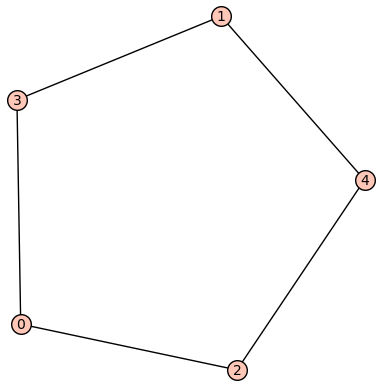

Graph 2: n=5, m=6


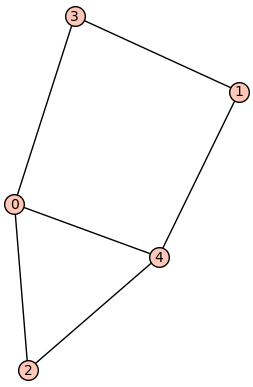

Graph 3: n=5, m=7


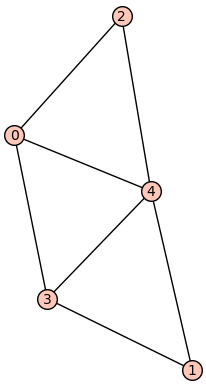

In [ ]:
def preview_graphs(filename='graphs_with_alpha_od_1.g6', count=3, start_index=0):
    """
    Show the first 'count' graphs from the file.
    """
    from sage.graphs.graph import Graph
    
    with open(filename, 'r') as f:
        for _ in range(start_index):
            next(f)  # skip to start_index

        for i, line in enumerate(f):
            if i >= count:
                break
            G = Graph(line.strip())
            print(f"Graph {i+1}: n={G.order()}, m={G.size()}")
            G.show()

preview_graphs(count=3, start_index=10)

Testirali bomo sledeče hipoteze.

In [ ]:
# Diameter properties

def prop_diameter_at_most_2(G):
   """
   H: Diameter of G is at most 2.
   """
   return G.diameter() <= 2

def prop_diameter_equal_to_2(G):
   """
   H: Diameter of G is equal to 2.
   """
   return G.diameter() == 2

def prop_complement_diameter_at_most_2(G):
   """
   H: The complement of G has diameter at most 2.
   """
   return G.complement().diameter() <= 2

# Radius properties

def prop_pradius_1(G):
   """
   H: Radius of G is equal to 1.
   """
   return G.radius() == 1

def prop_radius_equals_diameter(G):
   """
   H: Radius of G equals its diameter.
   """
   return G.radius() == G.diameter()

# Degree properties

def prop_min_degree_at_least_2(G):
   """
   H: G has minimum degree at least 2.
   """
   return min(G.degree()) >= 2

def prop_min_degree_at_least_3(G):
   """
   H: Minimum degree of G is at least 3.
   """
   return min(G.degree()) >= 3

def prop_average_degree_at_least_3(G):
   """
   H: Average degree of G is at least 3.
   """
   return G.average_degree() >= 3

def prop_min_degree_equals_half_order(G):
   """
   H: Minimum degree is at least n / 2.
   """
   return min(G.degree()) >= G.order() / 2

def prop_regular(G):
   """
   H: G is regular.
   """
   return len(set(G.degree())) == 1

def prop_min_degree_at_least_ceil_n_div_2(G):
   """
   H: Minimum degree is at least ceil(n / 2).
   """
   import math
   return min(G.degree()) >= math.ceil(G.order() / 2)


# Forbidden subgraph properties

def prop_claw_free(G):
   """
   H: G is claw-free.
   """
   return is_claw_free(G)

def prop_triangle_free(G):
   """
   H: G is triangle-free (has no induced C3).
   """
   from sage.graphs.graph_generators import graphs
   return G.subgraph_search(graphs.CycleGraph(3), induced=True) is None

def prop_no_induced_P4(G):
   """
   H: G has no induced P4.
   """
   from sage.graphs.graph_generators import graphs

   return G.subgraph_search(graphs.PathGraph(4), induced=True) is None

def prop_no_induced_C4(G):
   """
   H: G has no induced C4.
   """
   from sage.graphs.graph_generators import graphs

   return G.subgraph_search(graphs.CycleGraph(4), induced=True) is None

def prop_no_induced_K4(G):
   """
   H: G has no induced K4.
   """
   from sage.graphs.graph_generators import graphs

   return G.subgraph_search(graphs.CycleGraph(4), induced=True) is None

def prop_no_induced_odd_cycles_ge_5(G):
   """
   H: G has no induced odd cycles of length >= 5.
   """
   from sage.graphs.graph_generators import graphs

   n = G.order()
   for k in range(5, n + 1, 2):  # Odd cycles: 5, 7, 9, ...
      if G.subgraph_search(graphs.CycleGraph(k), induced=True) is not None:
         return False
   return True

# Girth properties

def prop_girth_at_least_4(G):
   """
   H: G has girth at least 4.
   """
   try:
       return G.girth() >= 4
   except:
       return True  # Acyclic graph


def prop_girth_at_least_5(G):
   """
   H: G has girth at least 5.
   """
   try:
      return G.girth() >= 5
   except:
      return True  # Acyclic graph

# Graph classes

def prop_bipartite(G):
   """
   H: G is bipartite.
   """
   return G.is_bipartite()

def prop_chordal(G):
   """
   H: G is chordal (no induced cycles of length >= 4).
   """
   return G.is_chordal()

def prop_line_graph(G):
   """
   H: G is a line graph.
   """
   return G.is_line_graph()

def prop_strongly_regular(G):
   """
   H: G is strongly regular.
   """
   return G.is_strongly_regular()

def prop_planar(G):
   """
   H: G is planar.
   """
   return G.is_planar()

# Connectivity properties

def prop_edge_connectivity_at_least_2(G):
   """
   H: Edge connectivity of G is at least 2.
   """
   return G.edge_connectivity() >= 2

def prop_complement_connected(G):
   """
   H: The complement of G is connected.
   """
   return G.complement().is_connected()

# Independence number properties

def prop_alpha_equals_2(G):
   """
   H: G has independence number equal to 2.
   """
   return G.independent_set(value_only=True) == 2

def prop_alpha_plus_alpha_od_equals_n(G):
   """
   H: alpha(G) + alpha_od(G) = n. We know alpha_od(G) = 1.
   """
   return G.independent_set(value_only=True) + 1 == G.order()

def prop_alpha_leq_2(G):
   """
   H: G has no independent set of size 3 or greater.
   """
   return G.independent_set(value_only=True) <= 2

def prop_alpha_square_equal_1(G):
   """
   H: alpha(G^2) == 1.
   The square graph G^2 has an independent set of size equal to 1.
   """
   return G.power(2).independent_set(value_only=True) == 1

# Coloring properties

def prop_chi_so_equals_n(G):
   """
   H: chi_so(G) = n (strong odd chromatic number equals order).
   Only computed for small graphs, since the computation is very slow.
   """
   if G.order() > 6:
      return None  # Skip large graphs
   return chi_so(G) == G.order()

def prop_chromatic_number_at_most_3(G):
   """
   H: G has chromatic number at most 3.
   """
   if G.order() > 10:
      return None  # Skip large graphs
   return G.chromatic_number() <= 3

# Distance properties

def prop_dist2_has_at_least_2_common_neighbors(G):
   """
   H: Every pair of vertices u, v with dist(u, v) = 2 has |N(u) ∩ N(v)| >= 2.
   """
   dist = G.distance_all_pairs()
   V = list(G.vertices())
   for i in range(len(V)):
      for j in range(i+1, len(V)):
         u, v = V[i], V[j]
         if dist[u][v] == 2:
            common = set(G.neighbors(u)).intersection(G.neighbors(v))
            if len(common) < 2:
               return False
   return True

# Edge density properties

def prop_dense(G):
   """
   H: G is dense (defined by having more than half of possible edges).
   """
   n = G.order()
   m = G.size()
   max_edges = n * (n - 1) / 2
   return m > max_edges / 2

# Domination properties

def prop_domination_number_2(G):
   """
   H: G has domination number 2 (can dominate all vertices with 2 vertices).
   """
   return G.dominating_set(value_only=True) == 2

# Interesting properties

def prop_hamiltonian(G):
   """
   H: G has a Hamiltonian cycle.
   """
   try:
      return G.is_hamiltonian()
   except:
      return False


def prop_eulerian(G):
   """
   H: G has an Eulerian cycle.
   """
   return G.is_eulerian()

In [ ]:
def test_property_necessity(prop, prop_name, graphs_with_alpha_od_1, random_seed=42, double_print=print):
   """
   Test necessity: alpha_od(G) = 1  =>  prop(G)

   Searches for a list of counterexamples. If counterexamples is empty, then the property appears necessary. Prints statistics related to testing the property.
   """
   import random
   random.seed(int(random_seed))

   counterexamples = []
   stats = {}

   for G in graphs_with_alpha_od_1:
      n = G.order()

      if n not in stats:
         stats[n] = {"total": 0, "with_property": 0}
      stats[n]["total"] += 1

      prop_holds = prop(G)

      if prop_holds is None:
         continue

      if not prop_holds:
         counterexamples.append(G)
      else:
         stats[n]["with_property"] += 1

   double_print(f"Necessity test for {prop_name}")
   double_print(f"Tested {len(graphs_with_alpha_od_1)} graphs with alpha_od = 1.")
   double_print(f"Found {len(counterexamples)} counterexamples.")

   if counterexamples != []:
      double_print("Showing a random counterexample:")
      random_graph = random.choice(counterexamples)
      double_print(f"Counterexample graph in graph6 format: {random_graph.graph6_string()}")
      random_graph.show()
   else:
      double_print("No counterexamples found. The property appears necessary.")    
   
   double_print("\nStats (graphs with alpha_od=1 / satisfy property):")
   for n in sorted(stats.keys()):
      total = stats[n]["total"]
      with_property = stats[n]["with_property"]
      double_print(f"  n={n}: {total} / {with_property}")
   double_print()

def test_property_sufficiency(prop, prop_name, graphs_with_alpha_od_1, n_max=7, random_seed=42, double_print=print):
   """
   Test sufficiency: prop(G)  =>  alpha_od(G) = 1

   Returns a list of counterexamples. If the list is empty, then the property appears sufficient.
   """
   from sage.graphs.graph_generators import graphs
   import random
   random.seed(int(random_seed))

   counterexamples = []
   stats = {}

   for n in range(1, n_max + 1):
      if n not in stats:
         stats[n] = {"total": 0, "with_property": 0}

      for G in graphs(n, immutable=True):
         if not G.is_connected():
            continue

         prop_holds = prop(G)
         if prop_holds is None or not prop_holds: # We are looking for graphs with the property prop(G) == True
            continue

         stats[n]["total"] += 1

         if G in graphs_with_alpha_od_1:
            stats[n]["with_property"] += 1
         else:
            counterexamples.append(G)

   double_print(f"Sufficiency test for {prop_name}")
   double_print(f"Tested connected graphs with up to {n_max} vertices.")
   double_print(f"Found {len(counterexamples)} counterexamples.")

   if counterexamples != []:
      double_print("Showing a random counterexample:")
      random_graph = random.choice(counterexamples)
      double_print(f"Counterexample graph in graph6 format: {random_graph.graph6_string()}")
      random_graph.show()
   else:
      double_print("No counterexamples found. The property appears sufficient.")

   double_print("\nStats (graphs with property / have alpha_od=1):")
   for n in sorted(stats.keys()):
      total = stats[n]["total"]
      with_property = stats[n]["with_property"]
      double_print(f"  n={n}: {total} / {with_property}")
   double_print()

def run_all_tests(filename='graphs_with_alpha_od_1.g6', output_filename='test_results.txt', n_max=8):
   """
   Test necessity and sufficiency for each hypothesis. Print statistics to a test file.
   """

   with open(output_filename, 'w') as f:
      def double_print(text=''):
         """
         Print to console and write to file at the same time.
         """
         print(text)
         f.write(text + '\n')
      
      double_print(f"Loading graphs from {filename}...")
      graphs_with_alpha_od_1 = load_graphs_from_graph6(filename)
      double_print(f"Loaded {len(graphs_with_alpha_od_1)} graphs")

      properties = {
         # Diameter properties
         "Diameter at most 2": prop_diameter_at_most_2,
         "Diameter equal to 2": prop_diameter_equal_to_2,
         "Complement diameter at most 2": prop_complement_diameter_at_most_2,
         # Radius properties
         "Radius 1": prop_pradius_1,
         "Radius equals diameter": prop_radius_equals_diameter,
         # Degree properties
         "Min degree at least 2": prop_min_degree_at_least_2,
         "Min degree at least 3": prop_min_degree_at_least_3,
         "Average degree at least 3": prop_average_degree_at_least_3,
         "Min degree at least n/2": prop_min_degree_equals_half_order,
         "Min degree at least ceil(n/2)": prop_min_degree_at_least_ceil_n_div_2,
         "Regular": prop_regular,
         # Forbidden subgraph properties
         "Claw-free": prop_claw_free,
         "Triangle-free": prop_triangle_free,
         "No induced P4": prop_no_induced_P4,
         "No induced C4": prop_no_induced_C4,
         "No induced K4": prop_no_induced_K4,
         "No induced odd cycles >= 5": prop_no_induced_odd_cycles_ge_5,
         # Girth properties
         "Girth at least 4": prop_girth_at_least_4,
         "Girth at least 5": prop_girth_at_least_5,
         # Graph classes
         "Bipartite": prop_bipartite,
         "Chordal": prop_chordal,
         "Line graph": prop_line_graph,
         "Strongly regular": prop_strongly_regular,
         "Planar": prop_planar,
         # Connectivity properties
         "Edge connectivity at least 2": prop_edge_connectivity_at_least_2,
         "Complement connected": prop_complement_connected,
         # Independence number properties
         "Independence number = 2": prop_alpha_equals_2,
         "alpha(G) + alpha_od(G) = n": prop_alpha_plus_alpha_od_equals_n,
         "alpha(G) <= 2": prop_alpha_leq_2,
         "alpha(G^2) == 1": prop_alpha_square_equal_1,
         # Coloring properties
         "chi_so(G) = n": prop_chi_so_equals_n,
         "Chromatic number at most 3": prop_chromatic_number_at_most_3,
         # Distance properties
         "Dist-2 pairs have at least 2 common neighbors": prop_dist2_has_at_least_2_common_neighbors,
         # Edge density properties
         "Dense (>50% edges)": prop_dense,
         # Domination properties
         "Domination number 2": prop_domination_number_2,
         # Interesting properties
         "Hamiltonian": prop_hamiltonian,
         "Eulerian": prop_eulerian,
      }

      for name, prop in properties.items():
         double_print("="*70)
         double_print(f"Property: {name}")
         double_print("-"*70)

         test_property_necessity(prop, name, graphs_with_alpha_od_1, double_print=double_print)
         test_property_sufficiency(prop, name, graphs_with_alpha_od_1, n_max, double_print=double_print)

Loading graphs from graphs_with_alpha_od_1.g6...
Loaded 82186 graphs
Property: Diameter at most 2
----------------------------------------------------------------------
Necessity test for Diameter at most 2
Tested 82186 graphs with alpha_od = 1.
Found 0 counterexamples.
No counterexamples found. The property appears necessary.

Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 11
  n=6: 43 / 43
  n=7: 266 / 266
  n=8: 3042 / 3042
  n=9: 69645 / 69645
  n=10: 356 / 356
  n=11: 403 / 403
  n=12: 361 / 361
  n=13: 397 / 397
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Diameter at most 2
Tested connected graphs with up to 8 vertices.
Found 1243 cou

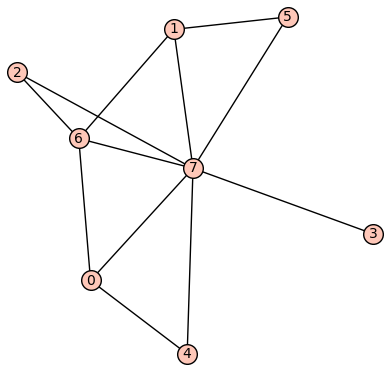


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 15 / 11
  n=6: 60 / 43
  n=7: 374 / 266
  n=8: 4155 / 3042

Property: Diameter equal to 2
----------------------------------------------------------------------
Necessity test for Diameter equal to 2
Tested 82186 graphs with alpha_od = 1.
Found 9 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: @


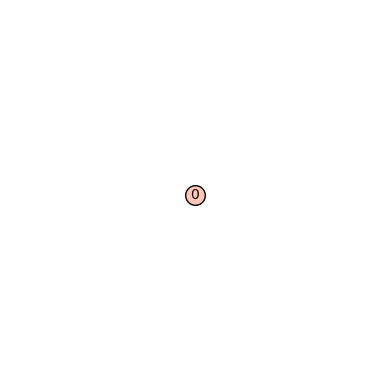


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 10
  n=6: 43 / 42
  n=7: 266 / 265
  n=8: 3042 / 3041
  n=9: 69645 / 69644
  n=10: 356 / 356
  n=11: 403 / 403
  n=12: 361 / 361
  n=13: 397 / 397
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Diameter equal to 2
Tested connected graphs with up to 8 vertices.
Found 1243 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?`FF{


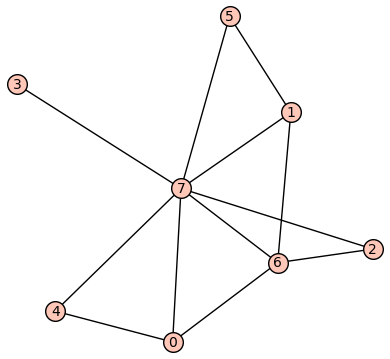


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 4 / 3
  n=5: 14 / 10
  n=6: 59 / 42
  n=7: 373 / 265
  n=8: 4154 / 3041

Property: Complement diameter at most 2
----------------------------------------------------------------------
Necessity test for Complement diameter at most 2
Tested 82186 graphs with alpha_od = 1.
Found 71117 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: H?qmvvv


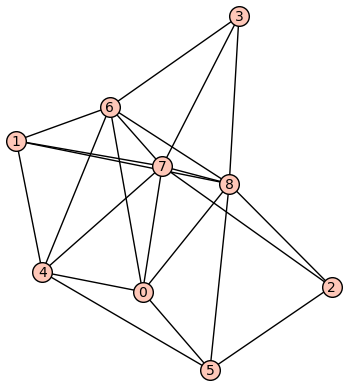


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 0
  n=5: 11 / 1
  n=6: 43 / 2
  n=7: 266 / 16
  n=8: 3042 / 186
  n=9: 69645 / 5042
  n=10: 356 / 75
  n=11: 403 / 85
  n=12: 361 / 95
  n=13: 397 / 114
  n=14: 417 / 150
  n=15: 429 / 192
  n=16: 449 / 224
  n=17: 433 / 243
  n=18: 470 / 267
  n=19: 465 / 284
  n=20: 479 / 309
  n=21: 475 / 340
  n=22: 477 / 363
  n=23: 487 / 365
  n=24: 494 / 397
  n=25: 493 / 424
  n=26: 243 / 209
  n=27: 496 / 433
  n=28: 491 / 454
  n=29: 495 / 458
  n=30: 361 / 340

Sufficiency test for Complement diameter at most 2
Tested connected graphs with up to 8 vertices.
Found 2922 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCXeew


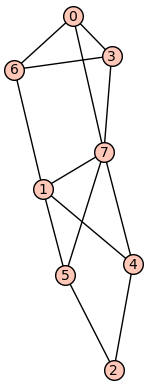


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 0 / 0
  n=5: 2 / 1
  n=6: 16 / 2
  n=7: 183 / 16
  n=8: 2926 / 186

Property: Radius 1
----------------------------------------------------------------------
Necessity test for Radius 1
Tested 82186 graphs with alpha_od = 1.
Found 73767 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCY^Fr\


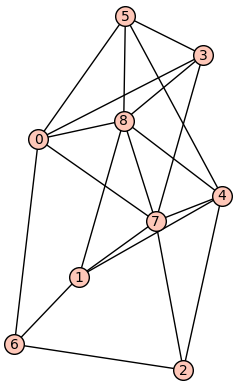


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 43 / 22
  n=7: 266 / 98
  n=8: 3042 / 633
  n=9: 69645 / 7627
  n=10: 356 / 11
  n=11: 403 / 7
  n=12: 361 / 2
  n=13: 397 / 5
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Radius 1
Tested connected graphs with up to 8 vertices.
Found 485 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?q~~{


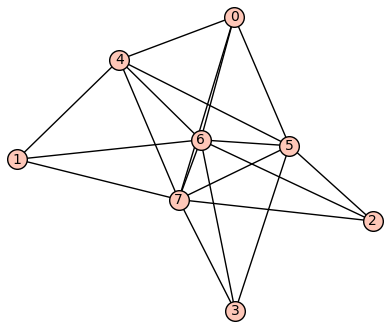


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 34 / 22
  n=7: 156 / 98
  n=8: 1044 / 633

Property: Radius equals diameter
----------------------------------------------------------------------
Necessity test for Radius equals diameter
Tested 82186 graphs with alpha_od = 1.
Found 8411 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: H?bL]z~


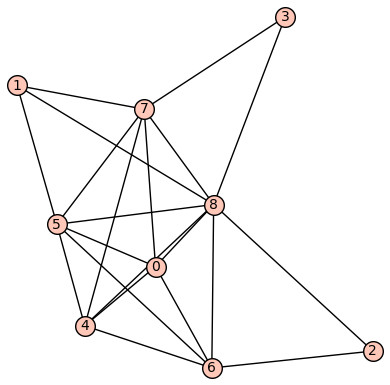


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 2
  n=5: 11 / 4
  n=6: 43 / 22
  n=7: 266 / 169
  n=8: 3042 / 2410
  n=9: 69645 / 62019
  n=10: 356 / 345
  n=11: 403 / 396
  n=12: 361 / 359
  n=13: 397 / 392
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Radius equals diameter
Tested connected graphs with up to 8 vertices.
Found 802 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCrrvg


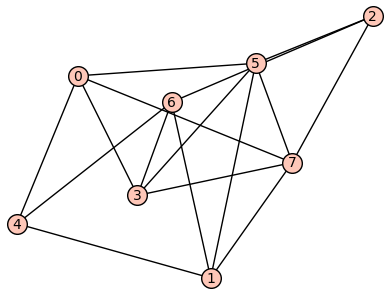


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 2 / 2
  n=5: 5 / 4
  n=6: 28 / 22
  n=7: 223 / 169
  n=8: 3151 / 2410

Property: Min degree at least 2
----------------------------------------------------------------------
Necessity test for Min degree at least 2
Tested 82186 graphs with alpha_od = 1.
Found 331 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCe[}~~


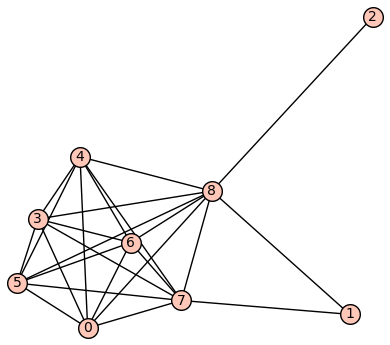


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 9
  n=6: 43 / 39
  n=7: 266 / 255
  n=8: 3042 / 2999
  n=9: 69645 / 69379
  n=10: 356 / 356
  n=11: 403 / 402
  n=12: 361 / 361
  n=13: 397 / 397
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Min degree at least 2
Tested connected graphs with up to 8 vertices.
Found 4719 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?bvv{


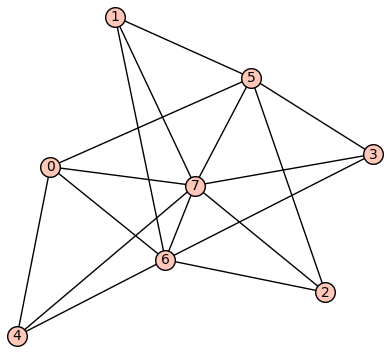


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 11 / 9
  n=6: 61 / 39
  n=7: 507 / 255
  n=8: 7442 / 2999

Property: Min degree at least 3
----------------------------------------------------------------------
Necessity test for Min degree at least 3
Tested 82186 graphs with alpha_od = 1.
Found 16938 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCrJa~~


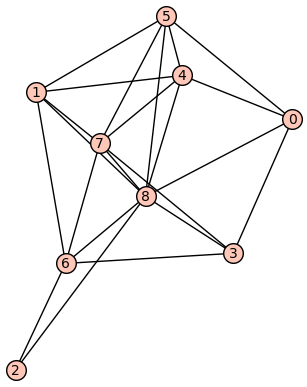


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 1
  n=5: 11 / 3
  n=6: 43 / 15
  n=7: 266 / 127
  n=8: 3042 / 1930
  n=9: 69645 / 54153
  n=10: 356 / 292
  n=11: 403 / 367
  n=12: 361 / 338
  n=13: 397 / 383
  n=14: 417 / 408
  n=15: 429 / 426
  n=16: 449 / 448
  n=17: 433 / 432
  n=18: 470 / 470
  n=19: 465 / 464
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Min degree at least 3
Tested connected graphs with up to 8 vertices.
Found 686 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GQjRe[


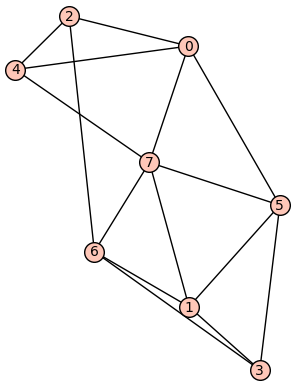


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 1 / 1
  n=5: 3 / 3
  n=6: 19 / 15
  n=7: 150 / 127
  n=8: 2589 / 1930

Property: Average degree at least 3
----------------------------------------------------------------------
Necessity test for Average degree at least 3
Tested 82186 graphs with alpha_od = 1.
Found 29 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: BW


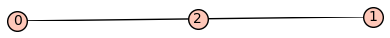


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 1
  n=5: 11 / 4
  n=6: 43 / 37
  n=7: 266 / 257
  n=8: 3042 / 3042
  n=9: 69645 / 69645
  n=10: 356 / 356
  n=11: 403 / 403
  n=12: 361 / 361
  n=13: 397 / 397
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Average degree at least 3
Tested connected graphs with up to 8 vertices.
Found 6688 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCZba[


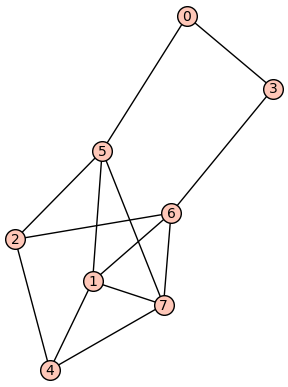


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 1 / 1
  n=5: 4 / 4
  n=6: 52 / 37
  n=7: 503 / 257
  n=8: 9469 / 3042

Property: Min degree at least n/2
----------------------------------------------------------------------
Necessity test for Min degree at least n/2
Tested 82186 graphs with alpha_od = 1.
Found 80746 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCReu~~


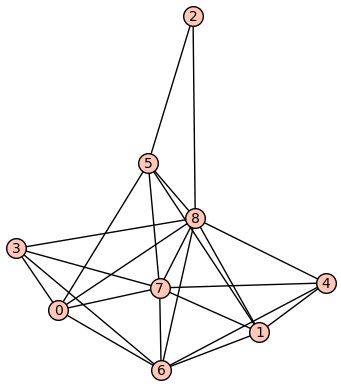


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 3
  n=6: 43 / 15
  n=7: 266 / 22
  n=8: 3042 / 367
  n=9: 69645 / 1017
  n=10: 356 / 6
  n=11: 403 / 1
  n=12: 361 / 4
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Min degree at least n/2
Tested connected graphs with up to 8 vertices.
Found 68 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?~vf{


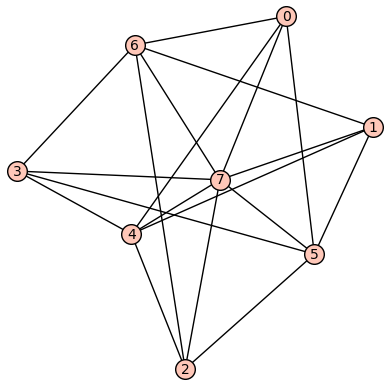


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 3 / 3
  n=6: 19 / 15
  n=7: 29 / 22
  n=8: 424 / 367

Property: Min degree at least ceil(n/2)
----------------------------------------------------------------------
Necessity test for Min degree at least ceil(n/2)
Tested 82186 graphs with alpha_od = 1.
Found 80746 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCReu~~


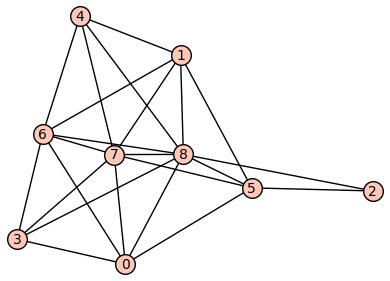


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 3
  n=6: 43 / 15
  n=7: 266 / 22
  n=8: 3042 / 367
  n=9: 69645 / 1017
  n=10: 356 / 6
  n=11: 403 / 1
  n=12: 361 / 4
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Min degree at least ceil(n/2)
Tested connected graphs with up to 8 vertices.
Found 68 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?~vf{


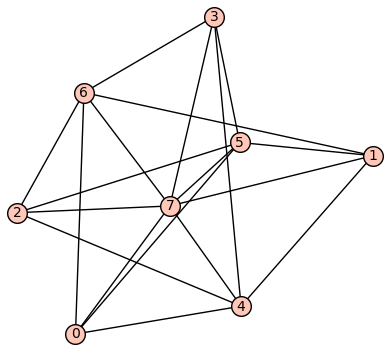


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 3 / 3
  n=6: 19 / 15
  n=7: 29 / 22
  n=8: 424 / 367

Property: Regular
----------------------------------------------------------------------
Necessity test for Regular
Tested 82186 graphs with alpha_od = 1.
Found 82146 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: J|c\dggpCP_


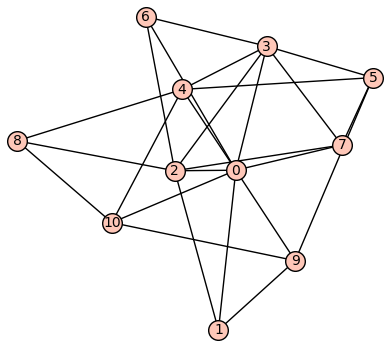


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 2
  n=5: 11 / 2
  n=6: 43 / 3
  n=7: 266 / 2
  n=8: 3042 / 10
  n=9: 69645 / 18
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Regular
Tested connected graphs with up to 8 vertices.
Found 11 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GFzvvW


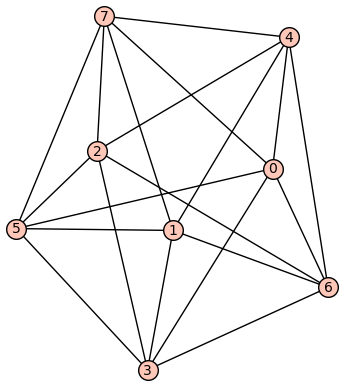


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 2 / 2
  n=5: 2 / 2
  n=6: 5 / 3
  n=7: 4 / 2
  n=8: 17 / 10

Property: Claw-free
----------------------------------------------------------------------
Necessity test for Claw-free
Tested 82186 graphs with alpha_od = 1.
Found 79325 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: VFCeJCR@@k@UEHqpaybt]^?ESEuYHegvxVB@qDTMfPM?


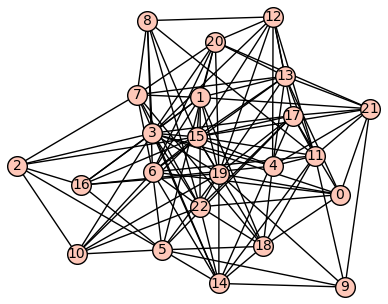


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 29
  n=7: 266 / 100
  n=8: 3042 / 434
  n=9: 69645 / 2280
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Claw-free
Tested connected graphs with up to 8 vertices.
Found 564 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: FQzmw


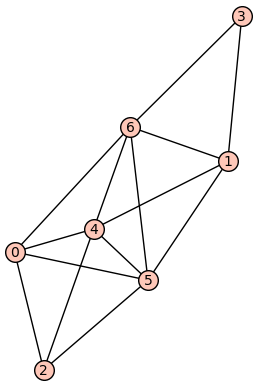


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 14 / 10
  n=6: 50 / 29
  n=7: 191 / 100
  n=8: 881 / 434

Property: Triangle-free
----------------------------------------------------------------------
Necessity test for Triangle-free
Tested 82186 graphs with alpha_od = 1.
Found 82172 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCQfDxv


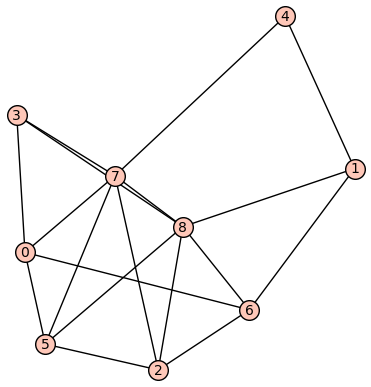


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 1
  n=6: 43 / 1
  n=7: 266 / 2
  n=8: 3042 / 3
  n=9: 69645 / 3
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Triangle-free
Tested connected graphs with up to 8 vertices.
Found 346 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?zTb_


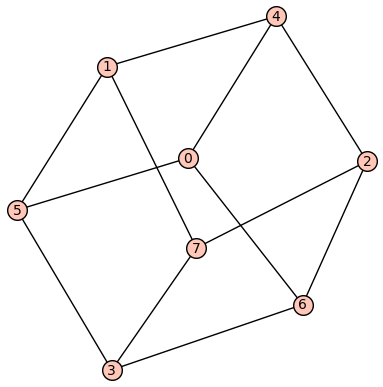


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 1
  n=5: 6 / 1
  n=6: 19 / 1
  n=7: 59 / 2
  n=8: 267 / 3

Property: No induced P4
----------------------------------------------------------------------
Necessity test for No induced P4
Tested 82186 graphs with alpha_od = 1.
Found 81717 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: [jOQWbjX{dHIP\{De}MM~zD`rS_Zdjql_Jv__SatO{F]~a[GMgKXvfX_GpRMbdHD


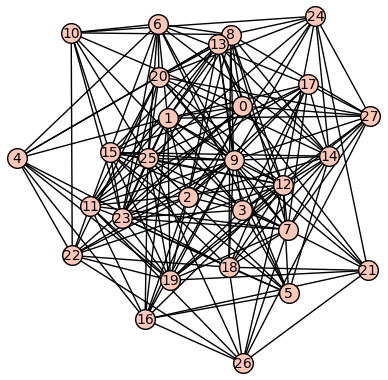


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 8
  n=6: 43 / 19
  n=7: 266 / 44
  n=8: 3042 / 111
  n=9: 69645 / 279
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for No induced P4
Tested connected graphs with up to 8 vertices.
Found 215 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?~vfw


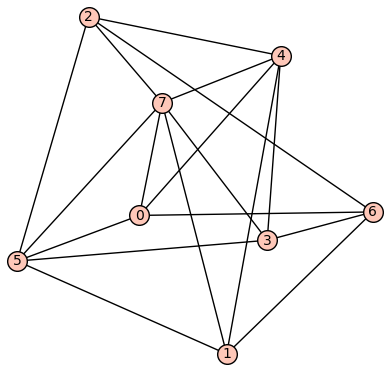


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 12 / 8
  n=6: 33 / 19
  n=7: 90 / 44
  n=8: 261 / 111

Property: No induced C4
----------------------------------------------------------------------
Necessity test for No induced C4
Tested 82186 graphs with alpha_od = 1.
Found 80587 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCQfFf{


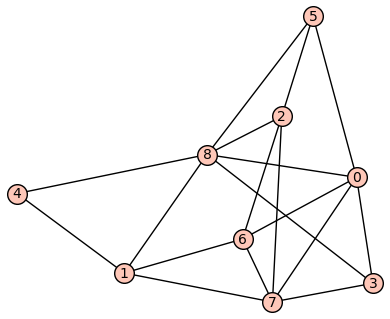


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 43 / 19
  n=7: 266 / 62
  n=8: 3042 / 240
  n=9: 69645 / 1261
  n=10: 356 / 2
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for No induced C4
Tested connected graphs with up to 8 vertices.
Found 2079 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?BDts


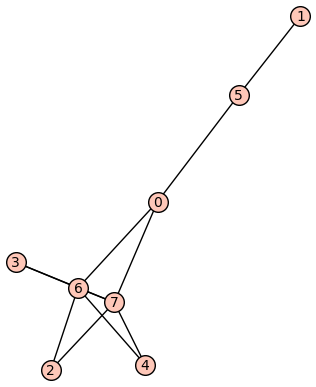


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 3
  n=5: 16 / 8
  n=6: 63 / 19
  n=7: 313 / 62
  n=8: 2014 / 240

Property: No induced K4
----------------------------------------------------------------------
Necessity test for No induced K4
Tested 82186 graphs with alpha_od = 1.
Found 80587 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCQfFf{


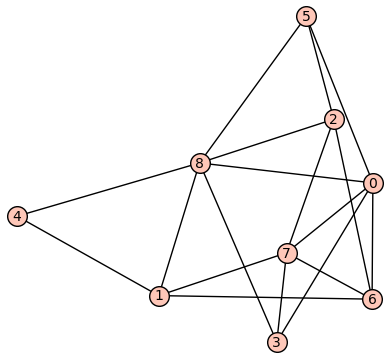


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 43 / 19
  n=7: 266 / 62
  n=8: 3042 / 240
  n=9: 69645 / 1261
  n=10: 356 / 2
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for No induced K4
Tested connected graphs with up to 8 vertices.
Found 2079 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?BDts


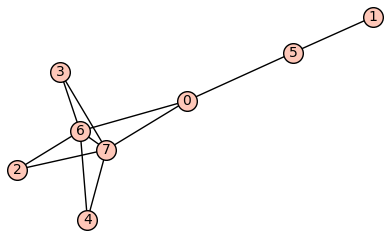


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 3
  n=5: 16 / 8
  n=6: 63 / 19
  n=7: 313 / 62
  n=8: 2014 / 240

Property: No induced odd cycles >= 5
----------------------------------------------------------------------
Necessity test for No induced odd cycles >= 5
Tested 82186 graphs with alpha_od = 1.
Found 53942 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCY]vHx


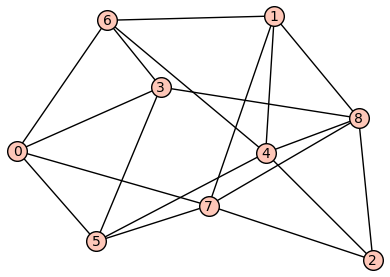


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 38
  n=7: 266 / 204
  n=8: 3042 / 1809
  n=9: 69645 / 26107
  n=10: 356 / 41
  n=11: 403 / 20
  n=12: 361 / 6
  n=13: 397 / 1
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for No induced odd cycles >= 5
Tested connected graphs with up to 8 vertices.
Found 6607 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCre^S


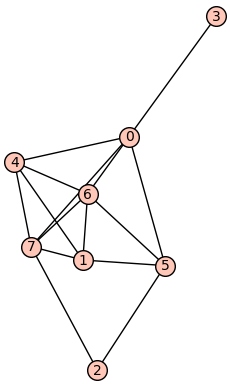


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 6 / 4
  n=5: 20 / 10
  n=6: 105 / 38
  n=7: 725 / 204
  n=8: 7816 / 1809

Property: Girth at least 4
----------------------------------------------------------------------
Necessity test for Girth at least 4
Tested 82186 graphs with alpha_od = 1.
Found 82172 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCQfDxv


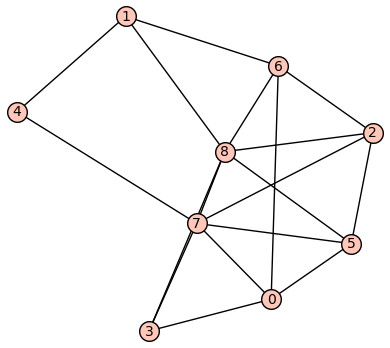


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 1
  n=6: 43 / 1
  n=7: 266 / 2
  n=8: 3042 / 3
  n=9: 69645 / 3
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Girth at least 4
Tested connected graphs with up to 8 vertices.
Found 346 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?zTb_


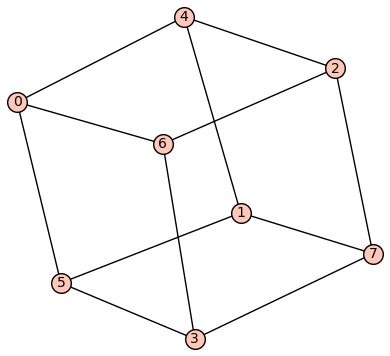


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 1
  n=5: 6 / 1
  n=6: 19 / 1
  n=7: 59 / 2
  n=8: 267 / 3

Property: Girth at least 5
----------------------------------------------------------------------
Necessity test for Girth at least 5
Tested 82186 graphs with alpha_od = 1.
Found 82182 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCvb~~~


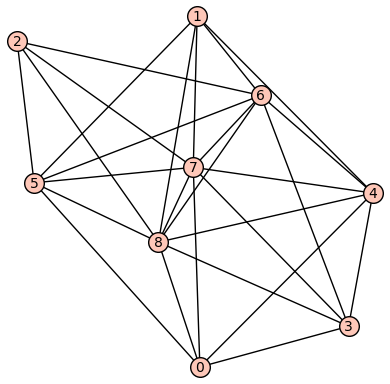


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 0
  n=5: 11 / 1
  n=6: 43 / 0
  n=7: 266 / 0
  n=8: 3042 / 0
  n=9: 69645 / 0
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Girth at least 5
Tested connected graphs with up to 8 vertices.
Found 78 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: F?AFo


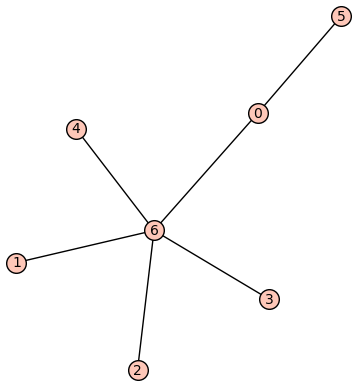


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 2 / 0
  n=5: 4 / 1
  n=6: 8 / 0
  n=7: 18 / 0
  n=8: 47 / 0

Property: Bipartite
----------------------------------------------------------------------
Necessity test for Bipartite
Tested 82186 graphs with alpha_od = 1.
Found 82182 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCvb~~~


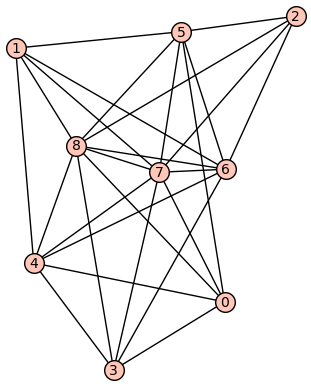


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 0
  n=6: 43 / 0
  n=7: 266 / 0
  n=8: 3042 / 0
  n=9: 69645 / 0
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Bipartite
Tested connected graphs with up to 8 vertices.
Found 250 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?`DE_


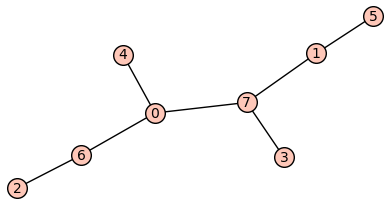


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 1
  n=5: 5 / 0
  n=6: 17 / 0
  n=7: 44 / 0
  n=8: 182 / 0

Property: Chordal
----------------------------------------------------------------------
Necessity test for Chordal
Tested 82186 graphs with alpha_od = 1.
Found 80907 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCrltz|


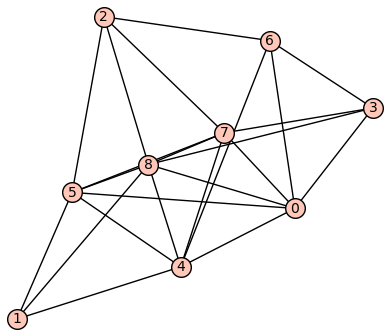


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 7
  n=6: 43 / 17
  n=7: 266 / 53
  n=8: 3042 / 200
  n=9: 69645 / 993
  n=10: 356 / 2
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Chordal
Tested connected graphs with up to 8 vertices.
Found 1684 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCQSnO


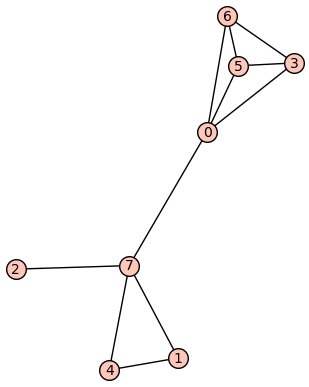


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 3
  n=5: 15 / 7
  n=6: 58 / 17
  n=7: 272 / 53
  n=8: 1614 / 200

Property: Line graph
----------------------------------------------------------------------
Necessity test for Line graph
Tested 82186 graphs with alpha_od = 1.
Found 82028 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCx}}~^


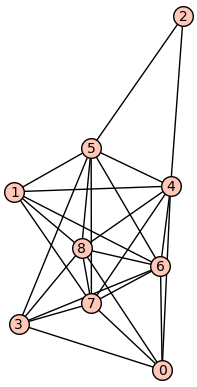


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 8
  n=6: 43 / 13
  n=7: 266 / 22
  n=8: 3042 / 38
  n=9: 69645 / 69
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Line graph
Tested connected graphs with up to 8 vertices.
Found 268 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: FCdeG


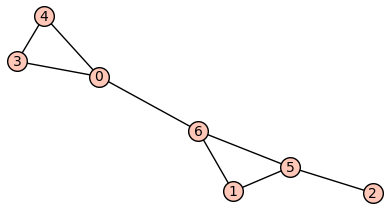


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 12 / 8
  n=6: 30 / 13
  n=7: 79 / 22
  n=8: 227 / 38

Property: Strongly regular
----------------------------------------------------------------------
Necessity test for Strongly regular
Tested 82186 graphs with alpha_od = 1.
Found 82181 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: H?zT~y~


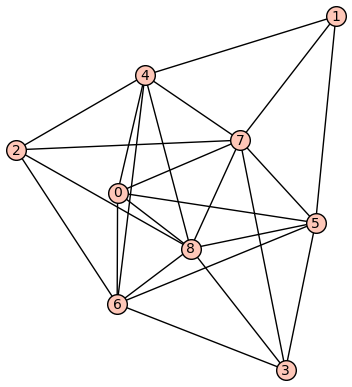


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 1
  n=5: 11 / 1
  n=6: 43 / 1
  n=7: 266 / 0
  n=8: 3042 / 1
  n=9: 69645 / 1
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Strongly regular
Tested connected graphs with up to 8 vertices.
Found 2 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: EFz_


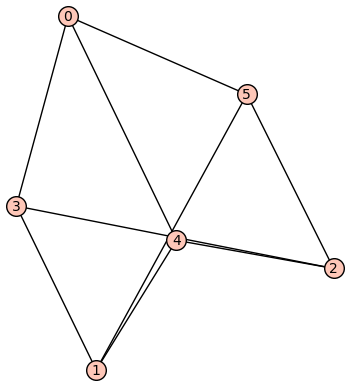


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 1 / 1
  n=5: 1 / 1
  n=6: 2 / 1
  n=7: 0 / 0
  n=8: 2 / 1

Property: Planar
----------------------------------------------------------------------
Necessity test for Planar
Tested 82186 graphs with alpha_od = 1.
Found 79891 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HQjVfvz


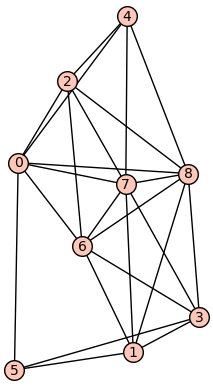


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 34
  n=7: 266 / 131
  n=8: 3042 / 499
  n=9: 69645 / 1613
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Planar
Tested connected graphs with up to 8 vertices.
Found 6067 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCpdrw


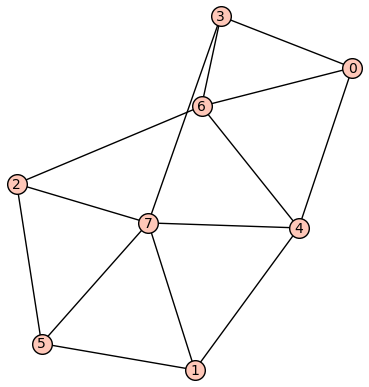


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 6 / 4
  n=5: 20 / 10
  n=6: 99 / 34
  n=7: 646 / 131
  n=8: 5974 / 499

Property: Edge connectivity at least 2
----------------------------------------------------------------------
Necessity test for Edge connectivity at least 2
Tested 82186 graphs with alpha_od = 1.
Found 331 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCe[}~~


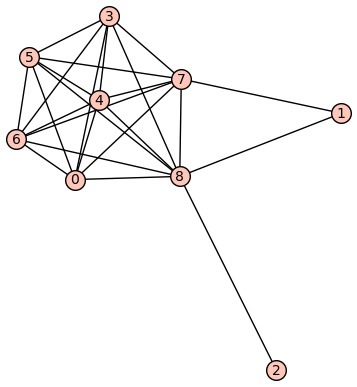


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 9
  n=6: 43 / 39
  n=7: 266 / 255
  n=8: 3042 / 2999
  n=9: 69645 / 69379
  n=10: 356 / 356
  n=11: 403 / 402
  n=12: 361 / 361
  n=13: 397 / 397
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Edge connectivity at least 2
Tested connected graphs with up to 8 vertices.
Found 4674 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?bmvo


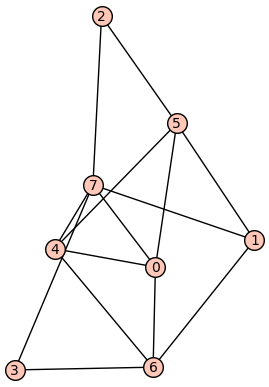


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 11 / 9
  n=6: 60 / 39
  n=7: 502 / 255
  n=8: 7403 / 2999

Property: Complement connected
----------------------------------------------------------------------
Necessity test for Complement connected
Tested 82186 graphs with alpha_od = 1.
Found 9202 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: H?qfR^~


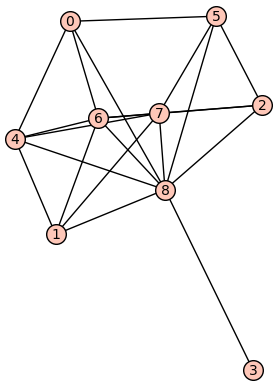


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 0
  n=5: 11 / 2
  n=6: 43 / 15
  n=7: 266 / 150
  n=8: 3042 / 2310
  n=9: 69645 / 61360
  n=10: 356 / 345
  n=11: 403 / 396
  n=12: 361 / 359
  n=13: 397 / 392
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Complement connected
Tested connected graphs with up to 8 vertices.
Found 8150 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCRcpw


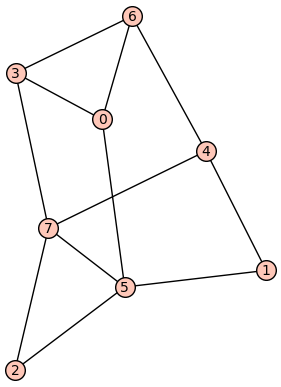


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 1 / 0
  n=5: 8 / 2
  n=6: 68 / 15
  n=7: 662 / 150
  n=8: 9888 / 2310

Property: Independence number = 2
----------------------------------------------------------------------
Necessity test for Independence number = 2
Tested 82186 graphs with alpha_od = 1.
Found 79939 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCRtvg


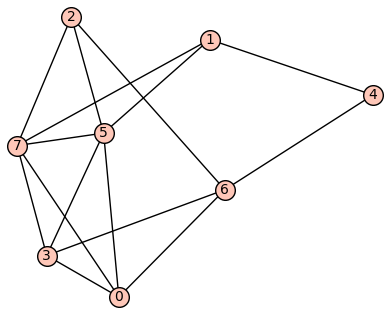


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 9
  n=6: 43 / 26
  n=7: 266 / 87
  n=8: 3042 / 354
  n=9: 69645 / 1767
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Independence number = 2
Tested connected graphs with up to 8 vertices.
Found 78 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: FQjUg


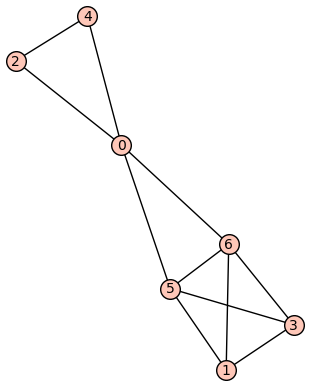


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 4 / 3
  n=5: 11 / 9
  n=6: 34 / 26
  n=7: 103 / 87
  n=8: 405 / 354

Property: alpha(G) + alpha_od(G) = n
----------------------------------------------------------------------
Necessity test for alpha(G) + alpha_od(G) = n
Tested 82186 graphs with alpha_od = 1.
Found 82184 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: H?zT~y~


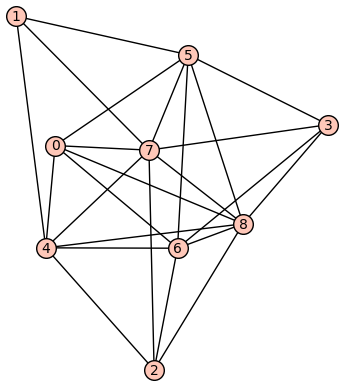


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 0
  n=5: 11 / 0
  n=6: 43 / 0
  n=7: 266 / 0
  n=8: 3042 / 0
  n=9: 69645 / 0
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for alpha(G) + alpha_od(G) = n
Tested connected graphs with up to 8 vertices.
Found 5 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: CF


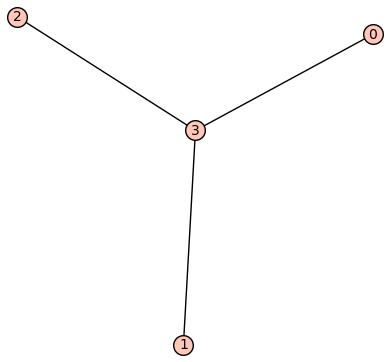


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 1 / 0
  n=5: 1 / 0
  n=6: 1 / 0
  n=7: 1 / 0
  n=8: 1 / 0

Property: alpha(G) <= 2
----------------------------------------------------------------------
Necessity test for alpha(G) <= 2
Tested 82186 graphs with alpha_od = 1.
Found 79930 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCZH~bf


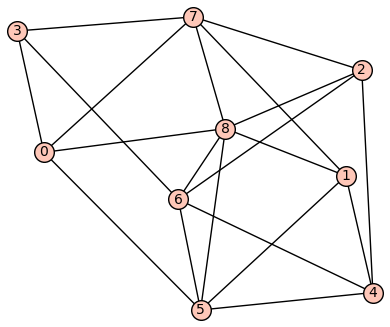


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 27
  n=7: 266 / 88
  n=8: 3042 / 355
  n=9: 69645 / 1768
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for alpha(G) <= 2
Tested connected graphs with up to 8 vertices.
Found 78 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: FQjUg


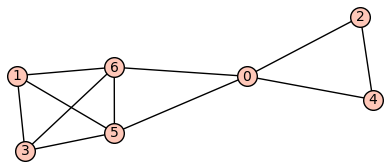


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 12 / 10
  n=6: 35 / 27
  n=7: 104 / 88
  n=8: 406 / 355

Property: alpha(G^2) == 1
----------------------------------------------------------------------
Necessity test for alpha(G^2) == 1
Tested 82186 graphs with alpha_od = 1.
Found 1 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: @


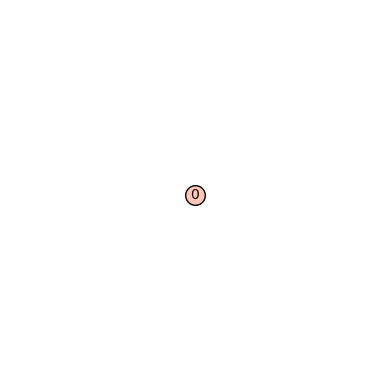


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 11
  n=6: 43 / 43
  n=7: 266 / 266
  n=8: 3042 / 3042
  n=9: 69645 / 69645
  n=10: 356 / 356
  n=11: 403 / 403
  n=12: 361 / 361
  n=13: 397 / 397
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for alpha(G^2) == 1
Tested connected graphs with up to 8 vertices.
Found 1243 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?`FF{


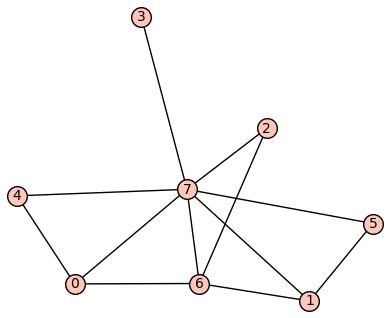


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 15 / 11
  n=6: 60 / 43
  n=7: 374 / 266
  n=8: 4155 / 3042

Property: chi_so(G) = n
----------------------------------------------------------------------
Necessity test for chi_so(G) = n
Tested 82186 graphs with alpha_od = 1.
Found 0 counterexamples.
No counterexamples found. The property appears necessary.

Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 11
  n=6: 43 / 43
  n=7: 266 / 0
  n=8: 3042 / 0
  n=9: 69645 / 0
  n=10: 356 / 0
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for chi_so(G) = n
Tested connected graphs with

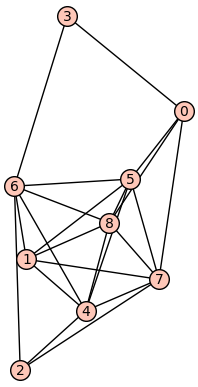


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 7
  n=6: 43 / 21
  n=7: 266 / 84
  n=8: 3042 / 555
  n=9: 69645 / 5786
  n=10: 356 / 19
  n=11: 403 / 0
  n=12: 361 / 0
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Chromatic number at most 3
Tested connected graphs with up to 8 vertices.
Found 5170 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?Beuo


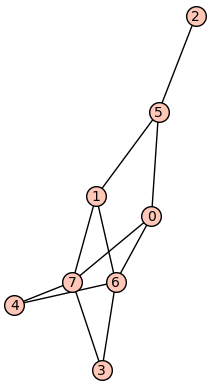


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 3
  n=5: 17 / 7
  n=6: 81 / 21
  n=7: 519 / 84
  n=8: 5218 / 555

Property: Dist-2 pairs have at least 2 common neighbors
----------------------------------------------------------------------
Necessity test for Dist-2 pairs have at least 2 common neighbors
Tested 82186 graphs with alpha_od = 1.
Found 63875 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HEhvD~}


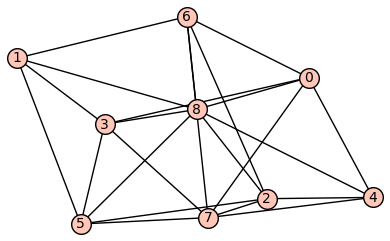


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 5
  n=6: 43 / 19
  n=7: 266 / 87
  n=8: 3042 / 813
  n=9: 69645 / 14981
  n=10: 356 / 26
  n=11: 403 / 36
  n=12: 361 / 30
  n=13: 397 / 37
  n=14: 417 / 34
  n=15: 429 / 44
  n=16: 449 / 53
  n=17: 433 / 63
  n=18: 470 / 62
  n=19: 465 / 78
  n=20: 479 / 115
  n=21: 475 / 129
  n=22: 477 / 123
  n=23: 487 / 156
  n=24: 494 / 154
  n=25: 493 / 197
  n=26: 243 / 102
  n=27: 496 / 237
  n=28: 491 / 241
  n=29: 495 / 271
  n=30: 361 / 212

Sufficiency test for Dist-2 pairs have at least 2 common neighbors
Tested connected graphs with up to 8 vertices.
Found 513 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: G?br~{


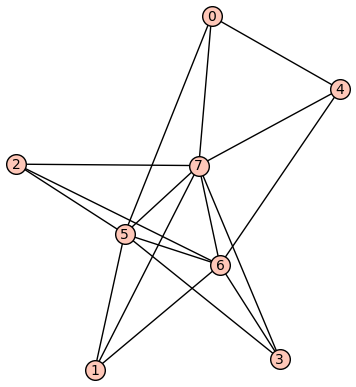


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 7 / 5
  n=6: 30 / 19
  n=7: 141 / 87
  n=8: 1259 / 813

Property: Dense (>50% edges)
----------------------------------------------------------------------
Necessity test for Dense (>50% edges)
Tested 82186 graphs with alpha_od = 1.
Found 11616 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: H?bFHz^


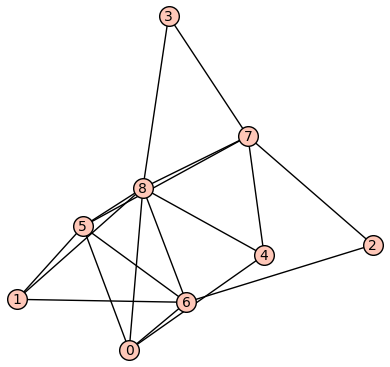


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 42
  n=7: 266 / 257
  n=8: 3042 / 2780
  n=9: 69645 / 62497
  n=10: 356 / 271
  n=11: 403 / 307
  n=12: 361 / 222
  n=13: 397 / 252
  n=14: 417 / 272
  n=15: 429 / 250
  n=16: 449 / 234
  n=17: 433 / 211
  n=18: 470 / 248
  n=19: 465 / 262
  n=20: 479 / 242
  n=21: 475 / 245
  n=22: 477 / 240
  n=23: 487 / 241
  n=24: 494 / 245
  n=25: 493 / 247
  n=26: 243 / 114
  n=27: 496 / 244
  n=28: 491 / 223
  n=29: 495 / 231
  n=30: 361 / 176

Sufficiency test for Dense (>50% edges)
Tested connected graphs with up to 8 vertices.
Found 2768 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GFzvVo


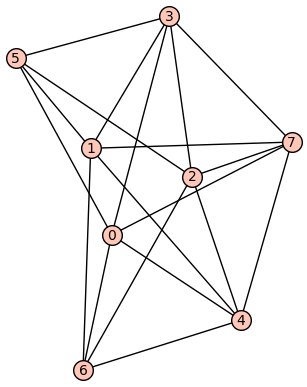


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 13 / 10
  n=6: 74 / 42
  n=7: 503 / 257
  n=8: 5267 / 2780

Property: Domination number 2
----------------------------------------------------------------------
Necessity test for Domination number 2
Tested 82186 graphs with alpha_od = 1.
Found 12920 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: HCrtrz~


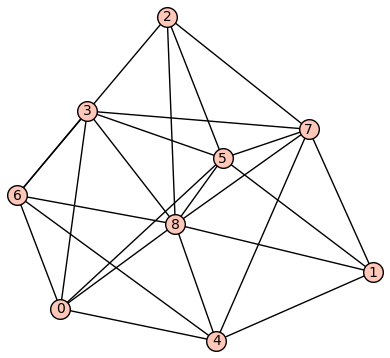


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 1
  n=5: 11 / 3
  n=6: 43 / 21
  n=7: 266 / 168
  n=8: 3042 / 2405
  n=9: 69645 / 61864
  n=10: 356 / 342
  n=11: 403 / 381
  n=12: 361 / 338
  n=13: 397 / 362
  n=14: 417 / 361
  n=15: 429 / 352
  n=16: 449 / 338
  n=17: 433 / 297
  n=18: 470 / 299
  n=19: 465 / 272
  n=20: 479 / 264
  n=21: 475 / 220
  n=22: 477 / 200
  n=23: 487 / 181
  n=24: 494 / 156
  n=25: 493 / 121
  n=26: 243 / 55
  n=27: 496 / 95
  n=28: 491 / 65
  n=29: 495 / 66
  n=30: 361 / 39

Sufficiency test for Domination number 2
Tested connected graphs with up to 8 vertices.
Found 7307 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCpev_


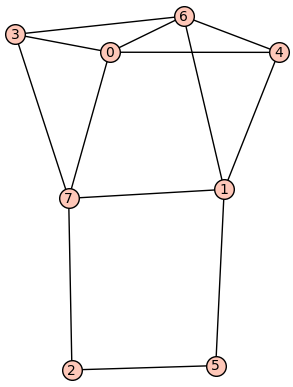


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 2 / 1
  n=5: 10 / 3
  n=6: 76 / 21
  n=7: 655 / 168
  n=8: 9162 / 2405

Property: Hamiltonian
----------------------------------------------------------------------
Necessity test for Hamiltonian
Tested 82186 graphs with alpha_od = 1.
Found 960 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCrUv{


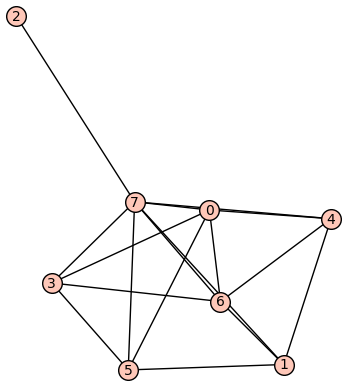


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 43 / 35
  n=7: 266 / 238
  n=8: 3042 / 2925
  n=9: 69645 / 68849
  n=10: 356 / 353
  n=11: 403 / 402
  n=12: 361 / 361
  n=13: 397 / 397
  n=14: 417 / 417
  n=15: 429 / 429
  n=16: 449 / 449
  n=17: 433 / 433
  n=18: 470 / 470
  n=19: 465 / 465
  n=20: 479 / 479
  n=21: 475 / 475
  n=22: 477 / 477
  n=23: 487 / 487
  n=24: 494 / 494
  n=25: 493 / 493
  n=26: 243 / 243
  n=27: 496 / 496
  n=28: 491 / 491
  n=29: 495 / 495
  n=30: 361 / 361

Sufficiency test for Hamiltonian
Tested connected graphs with up to 8 vertices.
Found 3429 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: GCZL]{


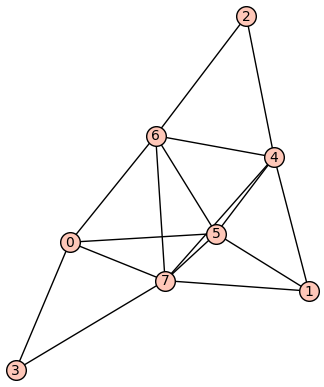


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 8 / 8
  n=6: 48 / 35
  n=7: 383 / 238
  n=8: 6196 / 2925

Property: Eulerian
----------------------------------------------------------------------
Necessity test for Eulerian
Tested 82186 graphs with alpha_od = 1.
Found 81587 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: H?qv@vU


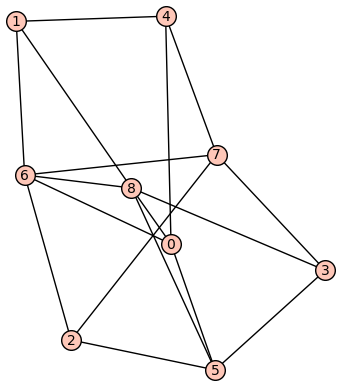


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 3
  n=6: 43 / 4
  n=7: 266 / 13
  n=8: 3042 / 60
  n=9: 69645 / 509
  n=10: 356 / 4
  n=11: 403 / 2
  n=12: 361 / 1
  n=13: 397 / 0
  n=14: 417 / 0
  n=15: 429 / 0
  n=16: 449 / 0
  n=17: 433 / 0
  n=18: 470 / 0
  n=19: 465 / 0
  n=20: 479 / 0
  n=21: 475 / 0
  n=22: 477 / 0
  n=23: 487 / 0
  n=24: 494 / 0
  n=25: 493 / 0
  n=26: 243 / 0
  n=27: 496 / 0
  n=28: 491 / 0
  n=29: 495 / 0
  n=30: 361 / 0

Sufficiency test for Eulerian
Tested connected graphs with up to 8 vertices.
Found 153 counterexamples.
Showing a random counterexample:
Counterexample graph in graph6 format: FQzUW


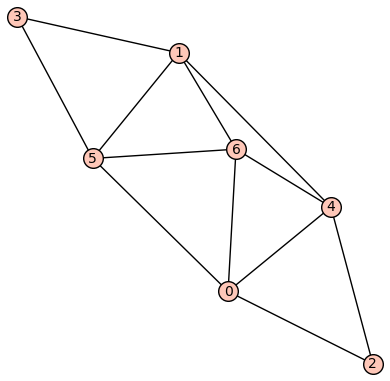


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 1 / 1
  n=5: 4 / 3
  n=6: 8 / 4
  n=7: 37 / 13
  n=8: 184 / 60



In [ ]:
run_all_tests()